Primero necesitamos instalar el paquete investpy e importar las librerías necesarias

In [ ]:
pip install investpy

In [ ]:
import investpy
import pandas as pd
from tqdm import tqdm

La función “get_hist_data” nos devuelve un diccionario cuyas claves son los símbolos de los productos de una tipología y un país definidos por el usuario y los valores son los dataframes (tablas de datos) asociadas a cada símbolo donde las columnas será el precio de apertura, cierre, máximo,... (a elección del usuario) y cada fila se corresponde con el registro del precio para un día determinado.

Para definir la función "get_hist_data" hacemos uso de una función auxiliar "get_symbols_list", que dado un país y una tipología de producto (fondo, acción, etf) nos devuelve una lista de todos los productos de ese tipo para ese país.

In [ ]:
def get_hist_data(from_date, to_date, product='stocks', country='spain', ls_cols=['Open', 'High', 'Low', 'Close']):
  """
  It retrieves daily historical data for a product, for a specified country in a specified date range.

  Arguments:
    from_date (str format: 'dd/mm/yyyy'): starting date for historical data
    to_date (str format: 'dd/mm/yyyy'): end date for historical data
    product (str): name of the type of poduct we want to retrieve data from, it can be 'stocks', 'funds' or 'etfs'
    country (str): country from which we want to retrieve data from
    ls_cols (list of str): columns we want to include

  Returns:
    d_res (dict): dictionary where keys are product symbols and values a dataframe with daily historical data
  """
  # Output
  d_res = dict()
  # STEP 1: Get all symbols for a type of product from a country
  ls_symbols = get_symbols_list(product,country)
  # STEP 2: Retrieve and store all historical data
  for symbol in tqdm(ls_symbols):
    try:
      # STEP 3: Try to get historical data for that symbol
      if product == 'stocks':
        df_hist = investpy.get_stock_historical_data(symbol, country=country, from_date=from_date, to_date=to_date)[ls_cols]
      elif product == 'funds':
        df_hist = investpy.get_fund_historical_data(symbol, country=country, from_date=from_date, to_date=to_date)[ls_cols]
      elif product == 'etfs':
        df_hist = investpy.get_etf_historical_data(symbol, country=country, from_date=from_date, to_date=to_date)[ls_cols]
    except Exception:
      pass
    else:
      # STEP 4: If it succeeded then check there are no missing values and assign df_hist to its corresponding symbol
      if df_hist.isnull().values.any() == False:
        d_res[symbol] = df_hist
  return d_res

def get_symbols_list(product, country):
  """
  It returns symbols that are needed to find historical data for

  Arguments:
    product (str): name of the type of poduct, it can be 'stocks', 'funds' or 'etfs'
    country (str): country from which we want to retrieve data from

  Returns:
    list of symbols (str) for a type of product from a specified country
  """
  if product == 'stocks':
    return investpy.get_stocks_list(country=country)
  elif product == 'funds':
    return investpy.get_funds_list(country=country)
  elif product == 'etfs':
    return investpy.get_etfs_list(country=country)

Si quisiéramos obtener el histórico de acciones españolas desde el 1 de enero de 2020 al 1 de febrero de 2021 llamamos a la función "get_hist_data", tal y como se observa a continuación.

In [ ]:
d_stocks = get_hist_data('01/01/2020', '01/02/2021', product='stocks', country='spain', ls_cols=['Open', 'High', 'Low', 'Close'])

100%|██████████| 234/234 [01:27<00:00,  2.67it/s]


La estructura de diccionario es útil ya que permite manipular los datos accediendo a la clave y comenzar a tratar los datos para la predicción.

Aquí vemos el histórico asociado a la clave BBVA, es decir, para la acción BBVA comercializada en España vemos los precios históricos diarios de apertura, cierre, máximo y mínimo.

In [ ]:
d_stocks['BBVA']

,Open,High,Low,Close
Date,,,,
2020-01-02,5.031,5.124,5.021,5.110
2020-01-03,5.078,5.078,5.016,5.054
2020-01-06,5.000,5.039,4.944,5.032
2020-01-07,5.051,5.079,4.983,5.010
2020-01-08,4.968,5.069,4.961,5.058
...,...,...,...,...
2021-01-26,3.912,3.976,3.891,3.944
2021-01-27,3.945,3.962,3.788,3.835
2021-01-28,3.782,3.956,3.782,3.941


La función “get_hist_df_data” nos permitirá poner todos los datos en un mismo dataframe no sólo diarios sino también por media semanal o mensual (a elección del usuario), posteriormente este dataframe puede ser exportado a csv para poder ser importado en excel.

In [ ]:
def get_hist_df_data(d_hist,resample=None):
  """
  It transforms a dictionary containing historical data for different items into a single dataframe indexed by time

  Arguments:
    d_hist (dict): dictionary where keys are product symbols and values a dataframe with daily historical data
    resample (str): 'W' if we want our historical data to be resampled by weekly mean, 'M' for monthly mean, if None it keeps being daily

  Returns:
    dataframe: containing all historical prices for all products
  """
  ls_df = []
  # For every symbol
  for symbol, df in d_hist.items():
    # Cast its index inta a datetime index
    df.index=pd.to_datetime(df.index)
    # If specified daily data will be converted into weekly or monthly
    if resample!=None:
      df=df.resample(resample).mean()
    # Symbol is included as an extra column
    df['Symbol'] = symbol
    # Transformed dataframe is added to df list
    ls_df.append(df)
  return pd.concat(ls_df)

Siguiendo el ejemplo de las acciones de España, usamos el diccionario "d_stocks" como argumento de la función "get_hist_df_data", y si queremos los datos agregados por su media semanal lo indicamos con 'W'.

In [ ]:
df_stocks_w = get_hist_df_data(d_stocks,'W')

A continuación podemos observar los primeros registros de los precios históricos de todas las acciones de España agregados semanalmente.

In [ ]:
df_stocks_w.head()

,Open,High,Low,Close,Symbol
Date,,,,,
2020-01-05,35.470,35.500,34.860,34.975,ACS
2020-01-12,34.698,34.868,34.276,34.472,ACS
2020-01-19,34.142,34.556,33.794,34.146,ACS
2020-01-26,33.542,33.782,33.088,33.242,ACS
2020-02-02,31.506,31.670,30.864,31.198,ACS


Para exportar los datos históricos a csv simplemente tenemos que:

In [ ]:
# Exportar a csv
df_stocks_w.to_csv('stocks_spain_weekly.csv',sep=';')

El siguiente apartado es para la visualización del número de productos en cada país

In [ ]:
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

# Se obtienen el número de productos de cada tipo por país
paises_fondos = dict(Counter(investpy.get_funds()['country']))
paises_acciones = dict(Counter(investpy.get_stocks()['country']))
paises_etfs = dict(Counter(investpy.get_etfs()['country']))

# Definimos una función que nos permita visualizar
def get_bars(dicc,min_prod):
  """
  Recibe:
    -dicc: Un diccionario donde la clave es el país y el valor el número de productos.
    -min_prod: El número mínimo de productos que un país debe tener para que sea mostrado
  """
  # Filtramos los países
  d_filtered = {x: count for x, count in dicc.items() if count >= min_prod}
  # Mostramos el grśfico de barras
  plt.figure(figsize=(15,8))
  plt.title(f'Países con más de {min_prod} productos')
  sns.barplot(x=list(d_filtered.keys()), y=list(d_filtered.values()))

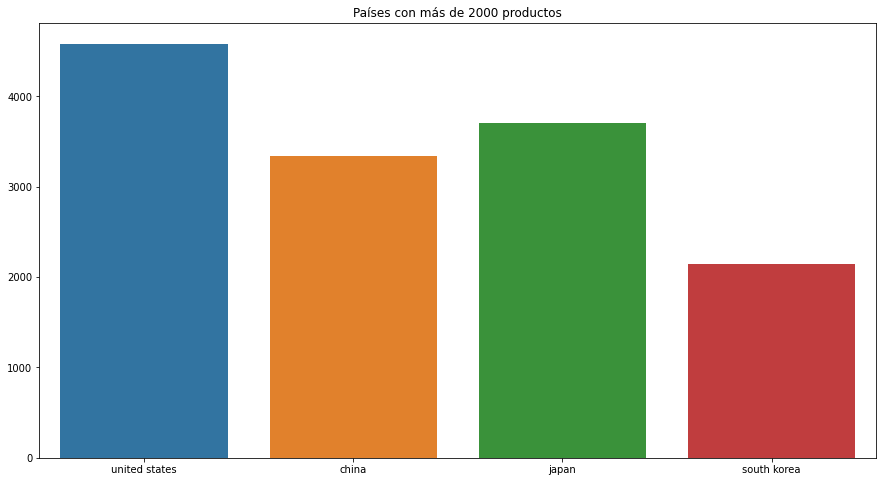

In [ ]:
# Si quisiésemos ver cuales son los países que tienen más de 2.000 acciones tendriamos que:
get_bars(paises_acciones,2000)